# Minimum Fisher Regularization (MFR) tomography


This page shows how to apply the MFR method to the specific case of tomography.

The basic theory of the MFR is described in [this page](../../user/theory/mfr.ipynb).


## Example Tomography Problem

As the example tomography problem, we consider the bolometer measurement and use the geometry matrix
calculated at `cherab.core` [documentation](https://www.cherab.info/demonstrations/bolometry/geometry_matrix_with_raytransfer.html#bolometer-geometry-raytransfer).


In [1]:
import pickle
from pathlib import Path
from pprint import pprint

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import AsinhNorm, ListedColormap, Normalize
from matplotlib.ticker import (
    LogFormatterSciNotation,
    MultipleLocator,
    PercentFormatter,
    SymmetricalLogLocator,
)
from mpl_toolkits.axes_grid1 import ImageGrid

from cherab.inversion import Mfr
from cherab.inversion.derivative import derivative_matrix
from cherab.inversion.tests import __path__ as test_path

plt.rcParams["figure.dpi"] = 150
TEST_DATA_PATH = Path(test_path[0]) / "data"

# custom Red colormap extracted from "RdBu_r"
cmap = plt.get_cmap("RdBu_r")
CMAP_RED = ListedColormap(cmap(np.linspace(0.5, 1.0, 256)))

In [2]:
# Load the results of the cherab.core demo
grid_data = np.load(TEST_DATA_PATH / "raytransfer_grid_data.npz")

# Extract the data
grid_centres = grid_data["grid_centres"]
voxel_map = grid_data["voxel_map"].squeeze()
mask = grid_data["mask"].squeeze()
gmat = grid_data["sensitivity_matrix"]

# Extract grid limits
dr = grid_centres[1, 0, 0] - grid_centres[0, 0, 0]
dz = grid_centres[0, 1, 1] - grid_centres[0, 0, 1]
rmin, rmax = grid_centres[0, 0, 0] - 0.5 * dr, grid_centres[-1, 0, 0] + 0.5 * dr
zmin, zmax = grid_centres[0, 0, 1] - 0.5 * dz, grid_centres[0, -1, 1] + 0.5 * dz

print(f"{grid_centres.shape = }")
print(f"{voxel_map.shape = }")
print(f"{mask.shape = }")
print(f"{gmat.shape = }")
print(f"gmat density: {np.count_nonzero(gmat) / gmat.size:.2%}")

grid_centres.shape = (40, 60, 2)
voxel_map.shape = (40, 60)
mask.shape = (40, 60)
gmat.shape = (48, 1210)
gmat density: 8.35%


The geometry matrix density is 8.35% so this problem is known as the sparse problem as well.


### Show the geometry matrix


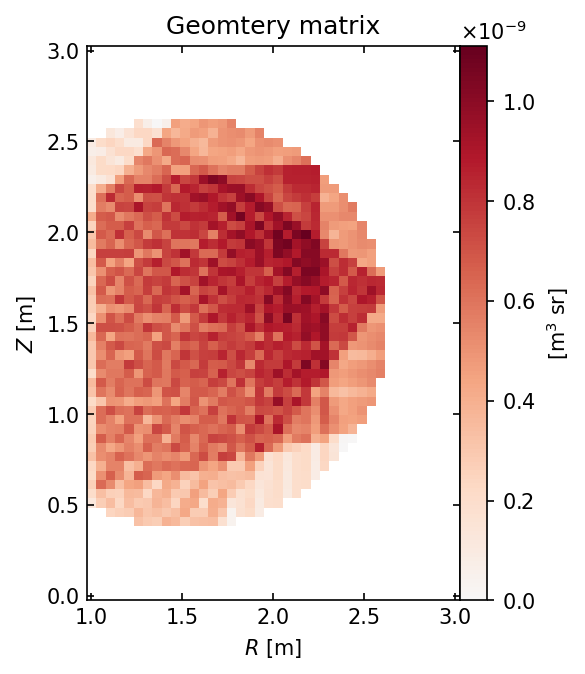

In [3]:
sensitivity_2d = np.full(voxel_map.shape, np.nan)
sensitivity_2d[mask[:, :]] = gmat.sum(axis=0)

fig, ax = plt.subplots()
image = ax.imshow(
    sensitivity_2d.T,
    origin="lower",
    cmap=CMAP_RED,
    extent=(rmin, rmax, zmin, zmax),
)
cbar = plt.colorbar(image, pad=0.0)
cbar.set_label("[m$^3$ sr]")
cbar.ax.ticklabel_format(style="sci", axis="y", useMathText=True)
cbar.ax.yaxis.set_offset_position("left")
ax.set_title("Geomtery matrix")
ax.set_xlabel("$R$ [m]")
ax.set_ylabel("$Z$ [m]")
ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

### Define phantom emission profile

As the test emission profile, we define the following phantom emission profile which is used in the `cherab.core`
[documentation](https://www.cherab.info/demonstrations/bolometry/inversion_with_raytransfer.html#bolometer-raytransfer-inversion) as well.


In [4]:
PLASMA_AXIS = np.array([1.5, 1.5])
LCFS_RADIUS = 1
RING_RADIUS = 0.5

RADIATION_PEAK = 1
CENTRE_PEAK_WIDTH = 0.05
RING_WIDTH = 0.025


def emission_function_2d(rz_point: np.ndarray) -> float:
    direction = rz_point - PLASMA_AXIS
    bearing = np.arctan2(direction[1], direction[0])

    # calculate radius of coordinate from magnetic axis
    radius_from_axis = np.hypot(*direction)
    closest_ring_point = PLASMA_AXIS + (0.5 * direction / radius_from_axis)
    radius_from_ring = np.hypot(*(rz_point - closest_ring_point))

    # evaluate pedestal -> core function
    if radius_from_axis <= LCFS_RADIUS:
        central_radiatior = RADIATION_PEAK * np.exp(-(radius_from_axis**2) / CENTRE_PEAK_WIDTH)

        ring_radiator = (
            RADIATION_PEAK * np.cos(bearing) * np.exp(-(radius_from_ring**2) / RING_WIDTH)
        )
        ring_radiator = max(0, ring_radiator)

        return central_radiatior + ring_radiator
    else:
        return 0


# Create a phantom vector
phantom = np.zeros(gmat.shape[1])

nr, nz = voxel_map.shape
for ir in range(nr):
    for iz in range(nz):
        index = voxel_map[ir, iz]
        if index < 0:
            continue
        phantom[index] = emission_function_2d(grid_centres[ir, iz])

# Create a 2D phantom
phantom_2d = np.full(voxel_map.shape, np.nan)
phantom_2d[mask[:, :]] = phantom

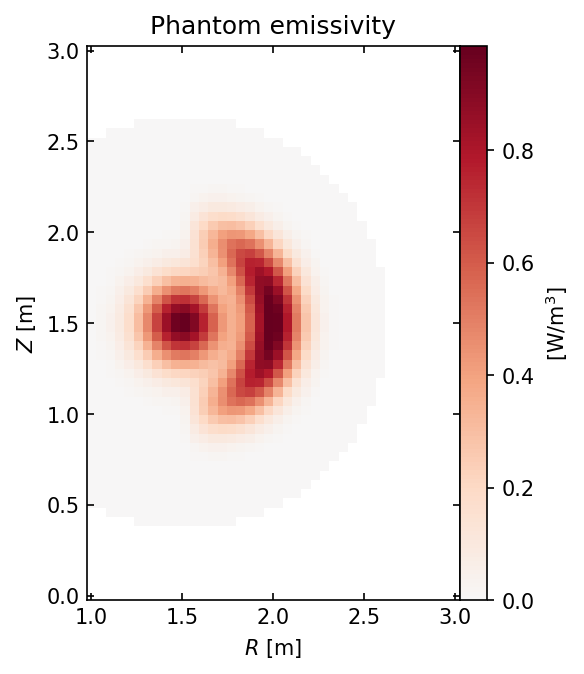

In [5]:
fig, ax = plt.subplots()
image = ax.imshow(
    phantom_2d.T,
    origin="lower",
    cmap=CMAP_RED,
    extent=(rmin, rmax, zmin, zmax),
)
cbar = plt.colorbar(image, pad=0.0)
cbar.set_label("[W/m$^3$]")
ax.set_title("Phantom emissivity")
ax.set_xlabel("$R$ [m]")
ax.set_ylabel("$Z$ [m]")
ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

### Compute the measurement data

The bolometer measurement data should be calculated by the ray-tracing method, however, we generate
the measurement data by the multiplication of the geometry matrix and the phantom profile.
As the noise, we add the Gaussian noise with the standard deviation of 1% of the maximum value of the
measurement data.


In [6]:
gmat /= 4.0 * np.pi  # devided by 4pi str to use with power measurements in [W]

In [7]:
data = gmat @ phantom

rng = np.random.default_rng()
data_w_noise = data + rng.normal(0, data.max() * 1.0e-2, data.size)
data_w_noise = np.clip(data_w_noise, 0, None)

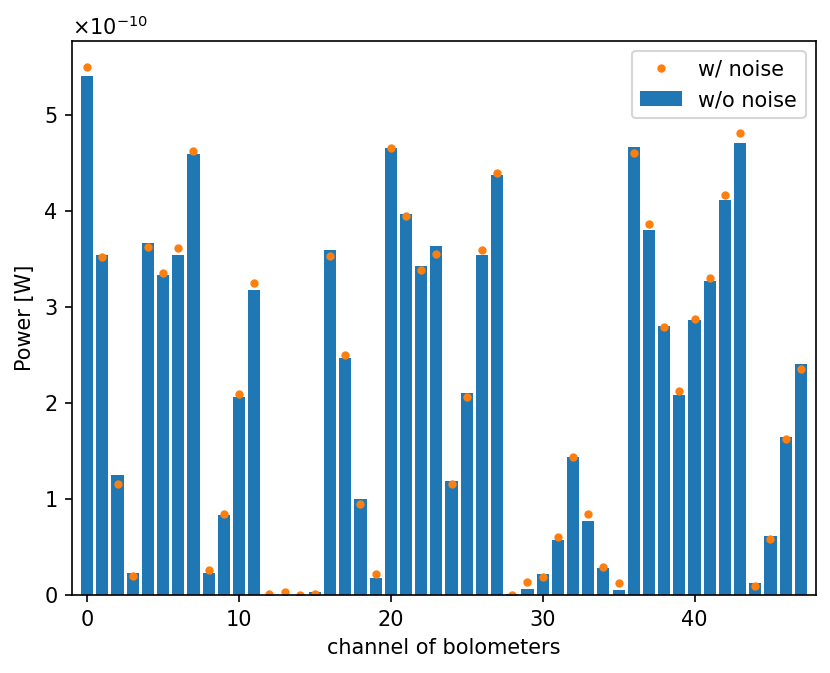

In [8]:
plt.bar(np.arange(data.size), data, label="w/o noise")
plt.plot(data_w_noise, ".", c="C1", label="w/ noise")
plt.legend()
plt.xlabel("channel of bolometers")
plt.ylabel("Power [W]")
plt.xlim(-1, data.size)
plt.ticklabel_format(style="sci", axis="y", useMathText=True)

## 1. Solve by the laplacian regularization

The laplacian regularization (or Phillips regularization<cite data-foot-t="Phillips1962-pk"></cite>) is the one of the most popular regularization methods.
However, this regularization tends to over-smooth the solution, and it is not suitable for the sparse problem.
Let's take a look this behavior by solving the tomography problem with the laplacian regularization.
As the optimization method, we use the L-curve method.


(<Figure size 960x720 with 1 Axes>,
 <Axes: xlabel='Regularization parameter $\\lambda$', ylabel='Curvature of L-curve'>)

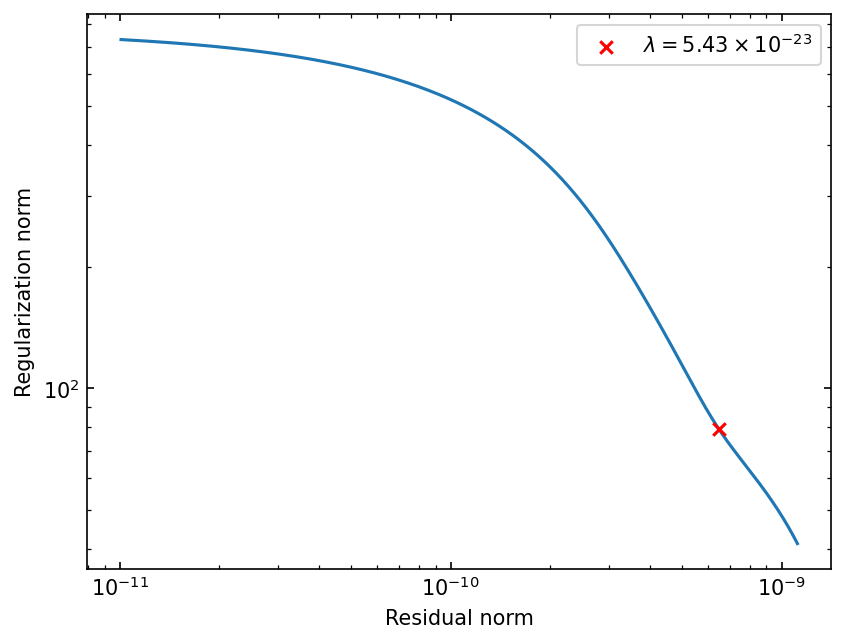

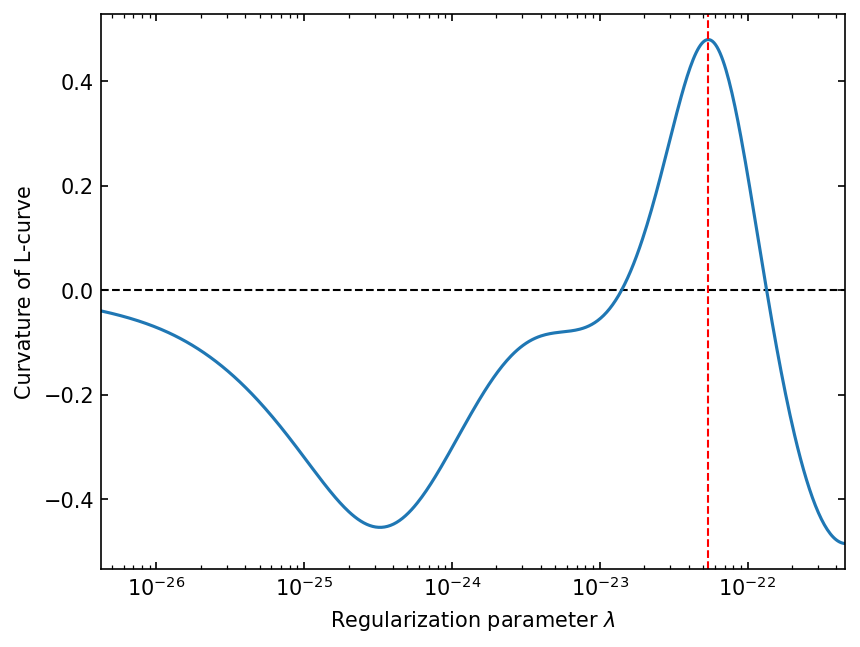

In [9]:
from cherab.inversion import Lcurve, compute_svd
from cherab.inversion.derivative import laplacian_matrix

lmat = laplacian_matrix(voxel_map.shape, (dr, dz), mask=mask)
s, u, basis = compute_svd(gmat, lmat.T @ lmat)

lcurve = Lcurve(s, u, basis, data=data_w_noise)
sol, status = lcurve.solve()
lcurve.plot_L_curve()
lcurve.plot_curvature()

Let us compare the solution with the phantom. The solution is over-smoothed and the details of the phantom are lost.


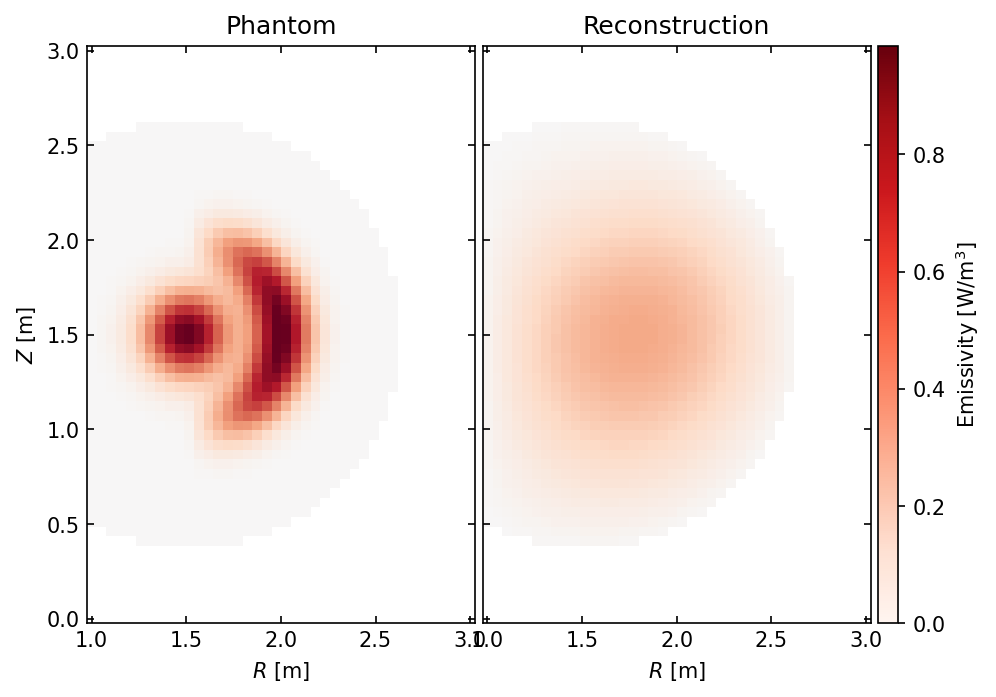

In [10]:
vmin = min(sol.min(), phantom.min())
vmax = max(sol.max(), phantom.max())

fig = plt.figure(figsize=(10, 5))
grids = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05, cbar_mode="single")
norm = Normalize(vmin=vmin, vmax=vmax)
for ax, value, label in zip(
    grids.axes_all, [phantom, sol], ["Phantom", "Reconstruction"], strict=True
):
    image = np.full(voxel_map.shape, np.nan)
    image[mask[:, :]] = value

    ax.imshow(
        image.T,
        origin="lower",
        cmap=CMAP_RED,
        extent=(rmin, rmax, zmin, zmax),
        norm=norm,
    )
    ax.set_title(label)
    ax.set_xlabel("$R$ [m]")
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

grids[0].set_ylabel("$Z$ [m]")
mappable = ScalarMappable(cmap="Reds", norm=norm)
cbar = plt.colorbar(mappable, cax=grids.cbar_axes[0])
cbar.set_label("Emissivity [W/m$^3$]")
ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

### Quantitative evaluation

Let us evaluate the solution quantitatively by the relative error, the total power, and the negative power values.
Each value is calculated as follows:

$$
\begin{gather}
\text{Relative error} = \frac{\left\| \mathbf{x}_\mathrm{recon} - \mathbf{x}_\mathrm{phan} \right\|_2}{\left\| \mathbf{x}_\mathrm{phan} \right\|_2},\\
\text{Total power} = \sum_i \mathbf{x}_iv_i,\\
\text{Negative power} = \sum_i \min\left\{0, \mathbf{x}_i\right\}v_i,
\end{gather}
$$

where $\mathbf{x}_\mathrm{recon}$ and $\mathbf{x}_\mathrm{phan}$ are the reconstructed and phantom profiles, respectively.
$\mathbf{x}_i$ represents the $i$-th element of the profile, and $v_i$ is the volume of the $i$-th
voxel calculated with the pappus theorem:

$$
v_i = \Delta r \Delta z \cdot 2\pi r_i,
$$

where $\Delta r$ and $\Delta z$ are the radial and vertical voxel sizes, respectively, and $r_i$ is the radial position of the $i$-th voxel.


In [11]:
volumes = dr * dz * 2.0 * np.pi * grid_centres[:, :, 0]
volumes = volumes[mask[:, :]]

print(
    f"The relative error           : {np.linalg.norm(sol - phantom) / np.linalg.norm(phantom):.2%}"
)
print("--------------------------------------------")
print(f"total power of phantom       : {phantom @ volumes:.4g} W")
print(f"total power of reconstruction: {sol @ volumes:.4g} W")
print(f"total negative power of reconstruction: {sol[sol < 0] @ volumes[sol < 0]:.4g} W")

The relative error           : 60.46%
--------------------------------------------
total power of phantom       : 4.848 W
total power of reconstruction: 5.065 W
total negative power of reconstruction: 0 W


## 2. Solve by the MFR regularization


### Prepare the derivative matrices

Before doing the MFR tomography, we need to create derivative matrices. Here $\mathbf{H}$ is defined as follows:

$$
\mathbf{H} \equiv \mathbf{D}_r^\mathsf{T} \mathbf{W} \mathbf{D}_r
    + \mathbf{D}_z^\mathsf{T} \mathbf{W} \mathbf{D}_z,
$$

where $\mathbf{D}_r$ and $\mathbf{D}_z$ are derivative matrices along the $r$ and $z$ coordinate direction, respectively.


In [12]:
dmat_r = derivative_matrix(voxel_map.shape, dr, axis=0, scheme="forward", mask=mask)
dmat_z = derivative_matrix(voxel_map.shape, dz, axis=1, scheme="forward", mask=mask)

dmat_pair = [(dmat_r, dmat_r), (dmat_z, dmat_z)]
pprint(dmat_pair)

[(<1210x1210 sparse matrix of type '<class 'numpy.float64'>'
	with 2376 stored elements in Compressed Sparse Column format>,
  <1210x1210 sparse matrix of type '<class 'numpy.float64'>'
	with 2376 stored elements in Compressed Sparse Column format>),
 (<1210x1210 sparse matrix of type '<class 'numpy.float64'>'
	with 2388 stored elements in Compressed Sparse Column format>,
  <1210x1210 sparse matrix of type '<class 'numpy.float64'>'
	with 2388 stored elements in Compressed Sparse Column format>)]


#### Reconstruct

Let us do the MFR tomography. `cherab.inversion` offers the `Mfr` class and simple `solve` method.
The `store_regularizers` parameter of the `solve` method is used to store the regularizer object
like `Lcurve` instance at each MFR iteration.


In [13]:
num_mfi = 4  # number of MFR iterations
eps = 1.0e-6  # small positive number to avoid division by zero
tol = 1.0e-3  # tolerance for the convergence criterion

mfr = Mfr(gmat, dmat_pair, data_w_noise)
sol, stats = mfr.solve(miter=num_mfi, eps=eps, tol=tol, store_regularizers=True)

✅ 00-th MFR iteration (Diff: 3.064e+01, Tolerance: 1.000e-03, lambda: 1.119e-23) (0:00:00.49)
✅ 01-th MFR iteration (Diff: 2.326e+00, Tolerance: 1.000e-03, lambda: 2.144e-25) (0:00:00.40)
✅ 02-th MFR iteration (Diff: 7.070e-01, Tolerance: 1.000e-03, lambda: 3.803e-26) (0:00:00.39)
✅ 03-th MFR iteration (Diff: 4.710e-01, Tolerance: 1.000e-03, lambda: 2.402e-26) (0:00:00.41)
Total elapsed time: 0:00:01.908909


### Evaluate the tomographic reconstruction


Let us compare the tomographic reconstruction with the phantom profile.
We can see that the MFR tomography reproduces the finer details of the phantom profile than the laplacian regularization.


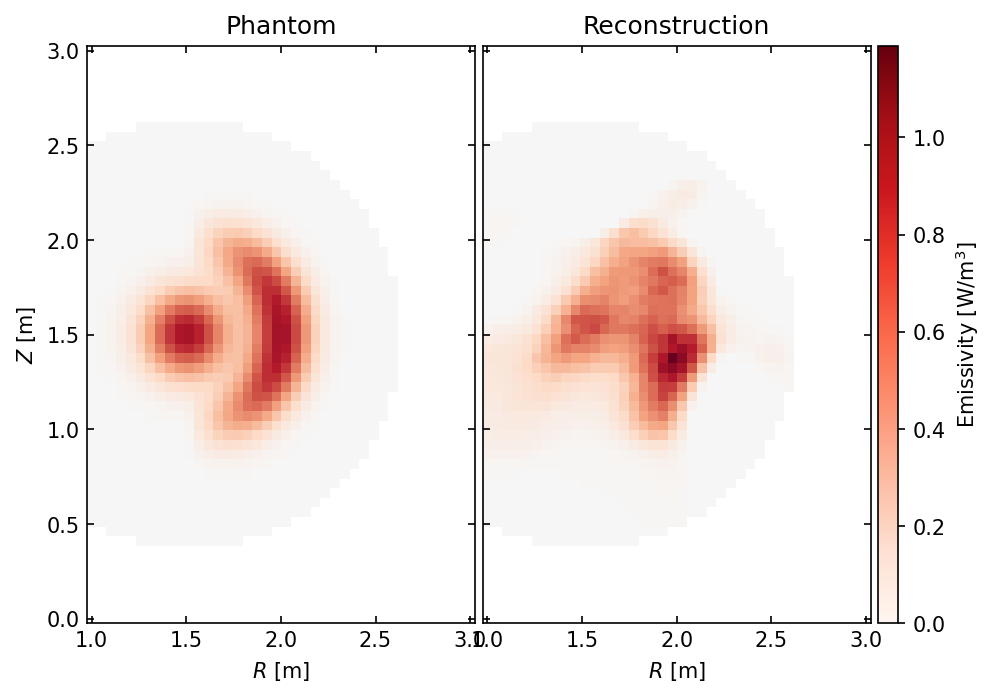

In [14]:
vmin = min(sol.min(), phantom.min())
vmax = max(sol.max(), phantom.max())

fig = plt.figure(figsize=(10, 5))
grids = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05, cbar_mode="single")
norm = Normalize(vmin=vmin, vmax=vmax)
for ax, value, label in zip(
    grids.axes_all, [phantom, sol], ["Phantom", "Reconstruction"], strict=True
):
    image = np.full(voxel_map.shape, np.nan)
    image[mask[:, :]] = value

    ax.imshow(
        image.T,
        origin="lower",
        cmap=CMAP_RED,
        extent=(rmin, rmax, zmin, zmax),
        norm=norm,
    )
    ax.set_title(label)
    ax.set_xlabel("$R$ [m]")

    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

grids[0].set_ylabel("$Z$ [m]")
mappable = ScalarMappable(cmap="Reds", norm=norm)
cbar = plt.colorbar(mappable, cax=grids.cbar_axes[0])
cbar.set_label("Emissivity [W/m$^3$]");

Quantitative evaluations are shown as follows.


#### L-curve and its curvature plot

The last solution's L-curve and its curvature are shown below.


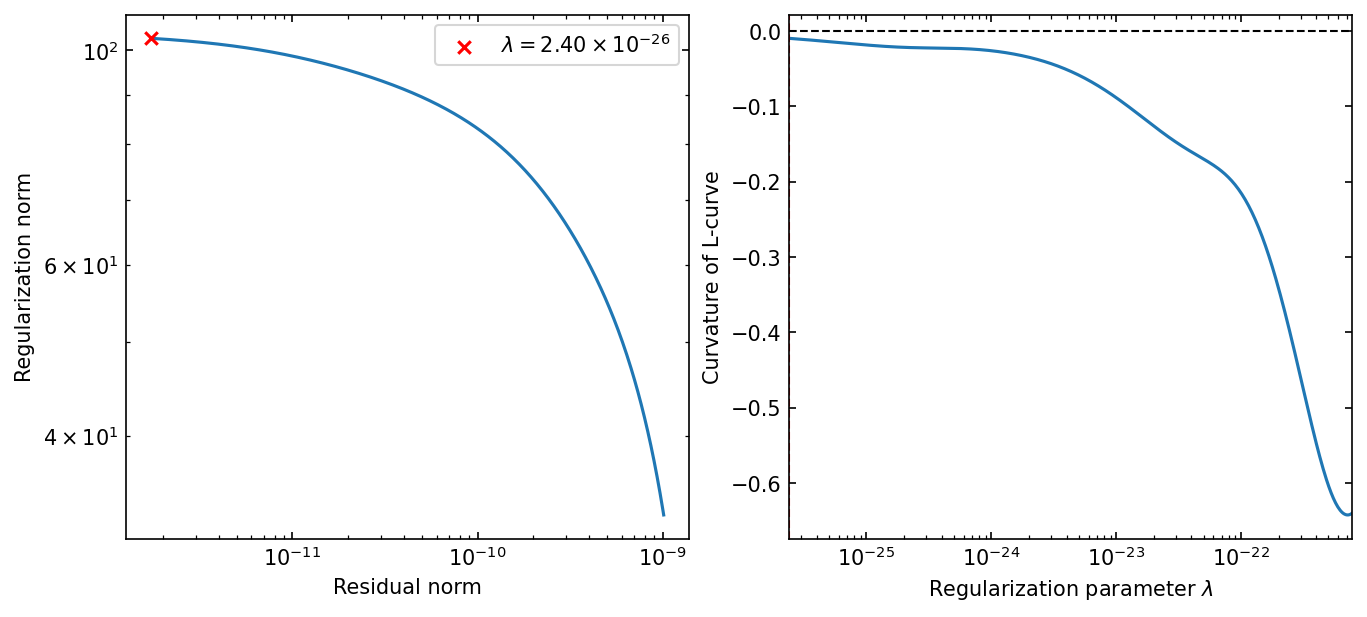

In [15]:
lcurve = stats["regularizer"]
fig, axes = plt.subplots(1, 2, dpi=150, figsize=(9, 4), layout="constrained")
lcurve.plot_L_curve(fig, axes[0])
lcurve.plot_curvature(fig, axes[1]);

The solution bases (see ) from 0-th to 18-th are shown below.


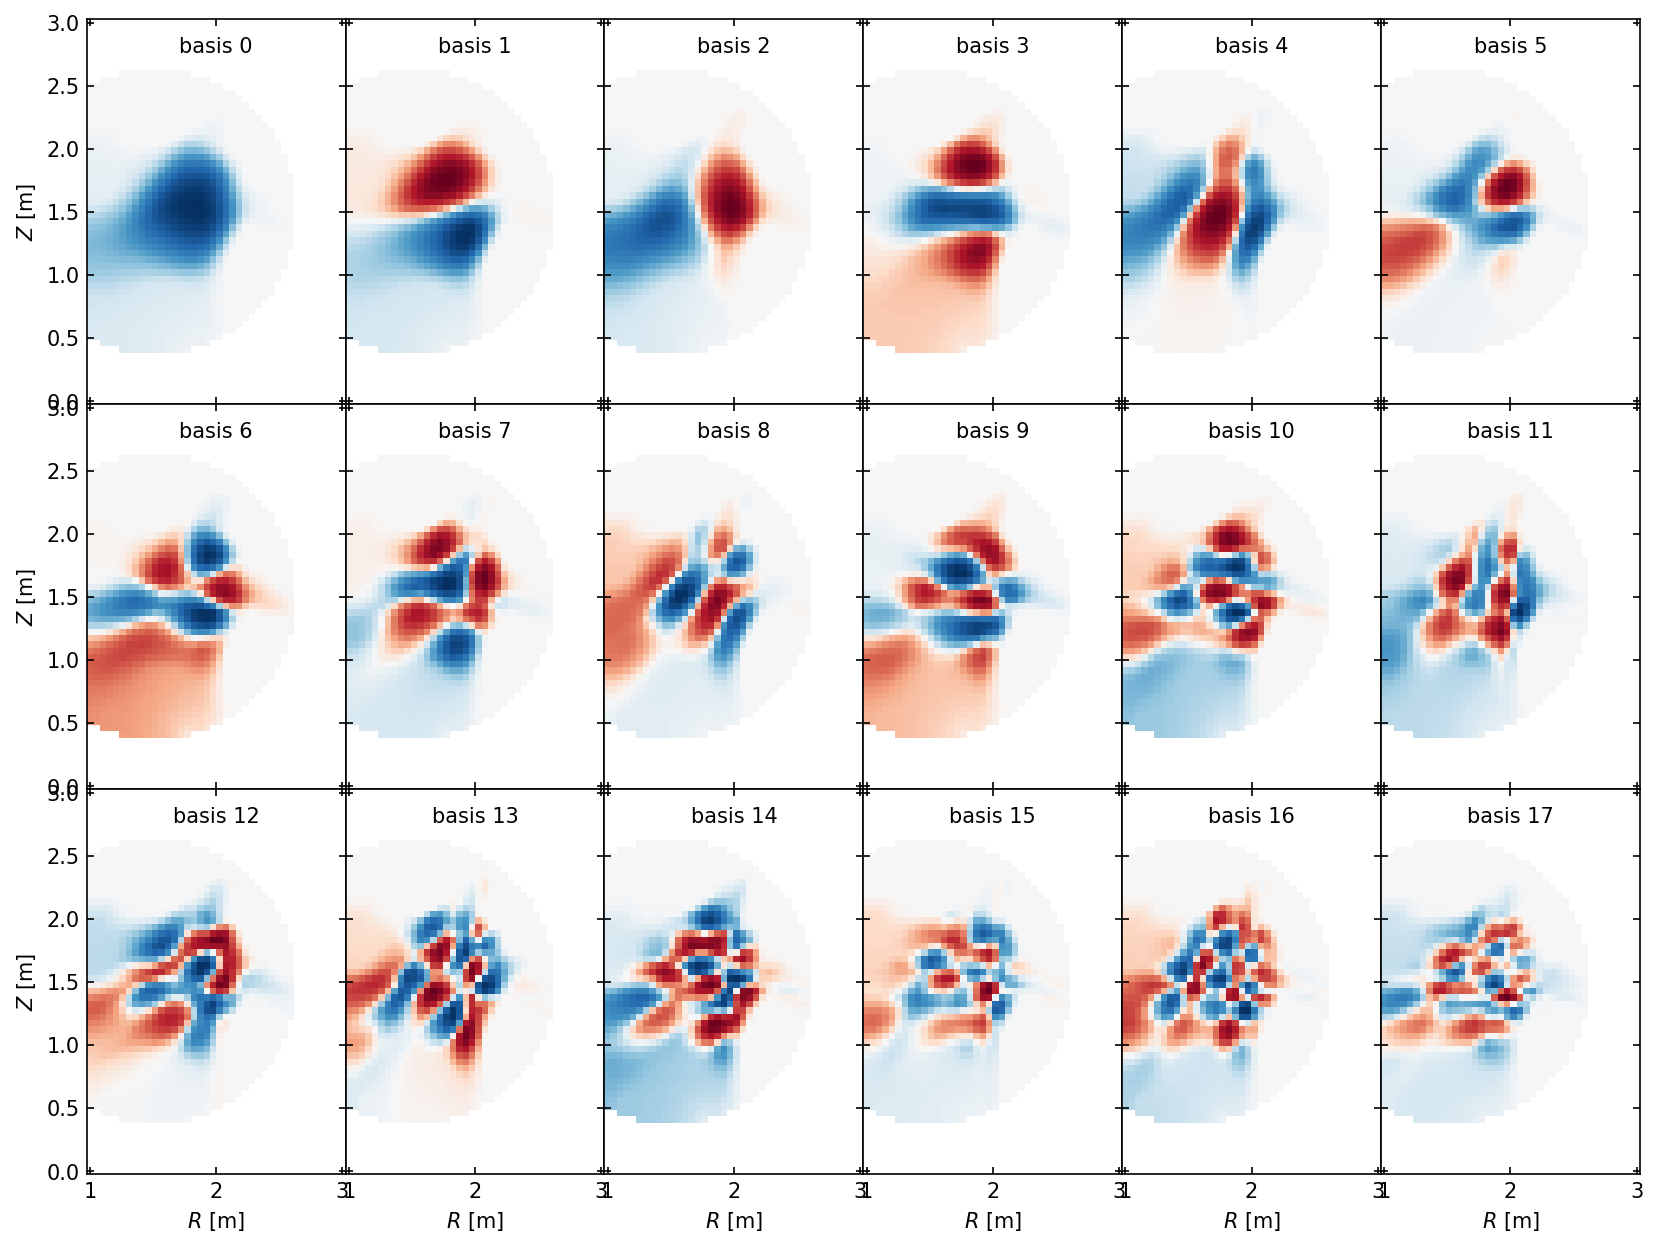

In [16]:
# Plot solution bases
fig = plt.figure(figsize=(16, 10))
grids = ImageGrid(
    fig,
    111,
    nrows_ncols=(3, 6),
    axes_pad=0.0,
    cbar_mode=None,
)

for i, ax in enumerate(grids.axes_all):
    profile2d = np.full(voxel_map.shape, np.nan)
    profile2d[mask[:, :]] = lcurve.basis[:, i]

    absolute = max(abs(lcurve.basis[:, i].min()), abs(lcurve.basis[:, i].max()))
    norm = AsinhNorm(vmin=-1 * absolute, vmax=absolute, linear_width=absolute * 1e-1)

    ax.imshow(
        profile2d.T,
        origin="lower",
        cmap="RdBu_r",
        extent=(rmin, rmax, zmin, zmax),
        norm=norm,
    )
    ax.set_xlabel("$R$ [m]") if i >= 12 else None
    ax.set_ylabel("$Z$ [m]") if i % 6 == 0 else None
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

    ax.text(
        0.5,
        0.93,
        f"basis {i}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )

### Compare the measurement powers


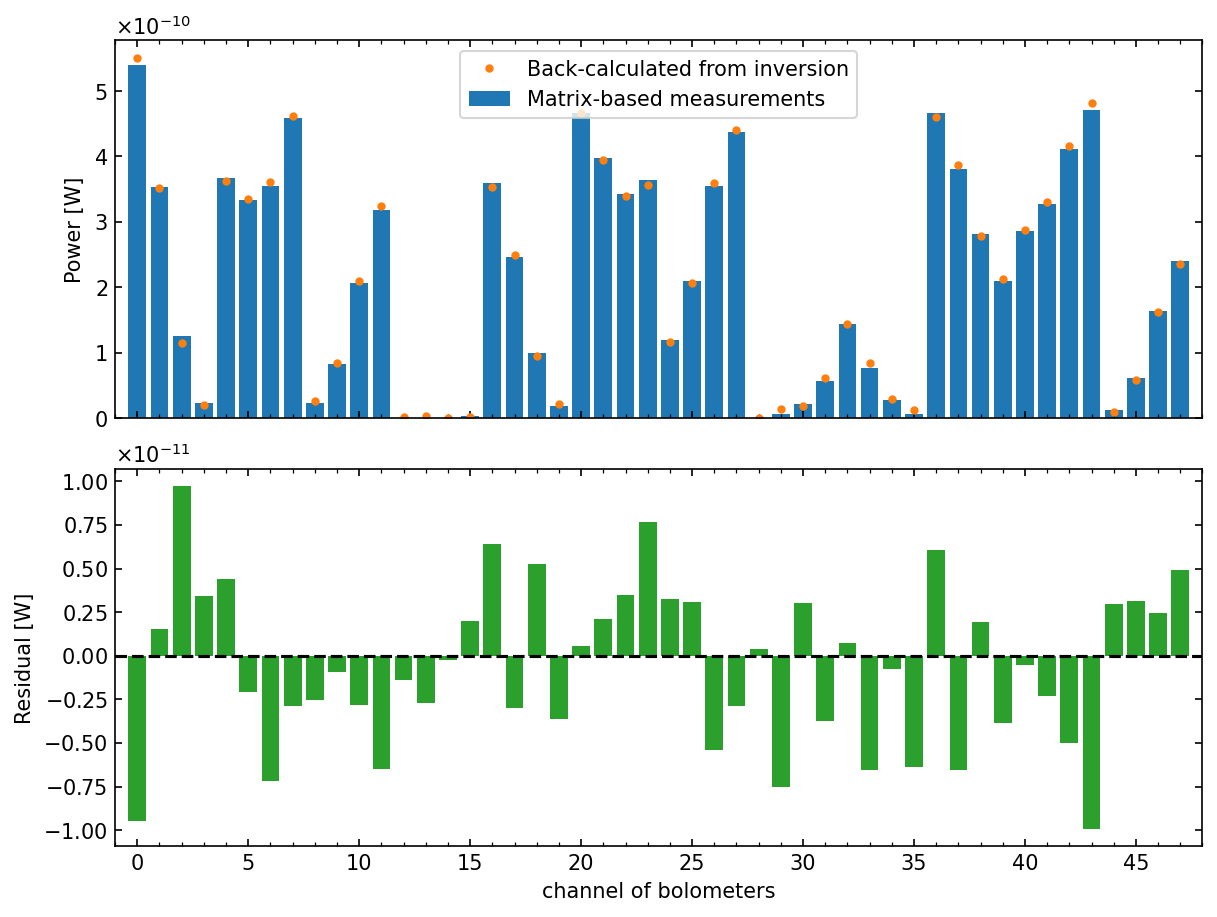

In [17]:
back_calculated_measurements = gmat @ sol

fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained", figsize=(8, 6), sharex=True)

# Plot the phantom and the back-calculated measurements
ax1.bar(np.arange(data.size), data, label="Matrix-based measurements")
ax1.plot(back_calculated_measurements, ".", color="C1", label="Back-calculated from inversion")
ax1.legend()
ax1.set_ylabel("Power [W]")
ax1.ticklabel_format(style="sci", axis="y", useMathText=True)
ax1.tick_params(axis="both", which="both", direction="in", top=True, right=True)
ax1.set_xlim(-1, data.size)
ax1.xaxis.set_major_locator(MultipleLocator(base=5))
ax2.xaxis.set_minor_locator(MultipleLocator(base=1))

# Plot the residuals between the measurements b and the back-calculated Tx (b - Tx)
ax2.axhline(0, color="k", linestyle="--")
ax2.bar(np.arange(data.size), data - back_calculated_measurements, color="C2")
ax2.set_xlabel("channel of bolometers")
ax2.set_ylabel("Residual [W]")
ax2.ticklabel_format(style="sci", axis="y", useMathText=True)
ax2.tick_params(axis="both", which="both", direction="in", top=True, right=True)

The measured power power calculated by multiplying the geomtery matrix by the emission vector and the back-calculated power calculated by multiplying the geometry matrix by the inverted emissivity are all in good agreement


In [18]:
print(
    f"The relative error of power measurements is {np.linalg.norm(data - back_calculated_measurements) / np.linalg.norm(data):.2%}"
)

The relative error of power measurements is 1.69%


In [19]:
print(
    f"The relative error           : {np.linalg.norm(sol - phantom) / np.linalg.norm(phantom):.2%}"
)
print("--------------------------------------------")
print(f"total power of phantom       : {phantom @ volumes:.4g} W")
print(f"total power of reconstruction: {sol @ volumes:.4g} W")
print(f"total negative power of reconstruction: {sol[sol < 0] @ volumes[sol < 0]:.4g} W")

The relative error           : 29.07%
--------------------------------------------
total power of phantom       : 4.848 W
total power of reconstruction: 4.891 W
total negative power of reconstruction: -1.345e-05 W


## Iteration history


As discribed in the [MFR definition section](../../user/theory/mfr.ipynb), MFR is the iterative method.
To see the convergence behavior, we investigate the iteration history.


### Reconstruction profiles history

Firstly, let us see the each iteration solution.
To clarify the negative values, we plot solutions with the arcsinh scale.


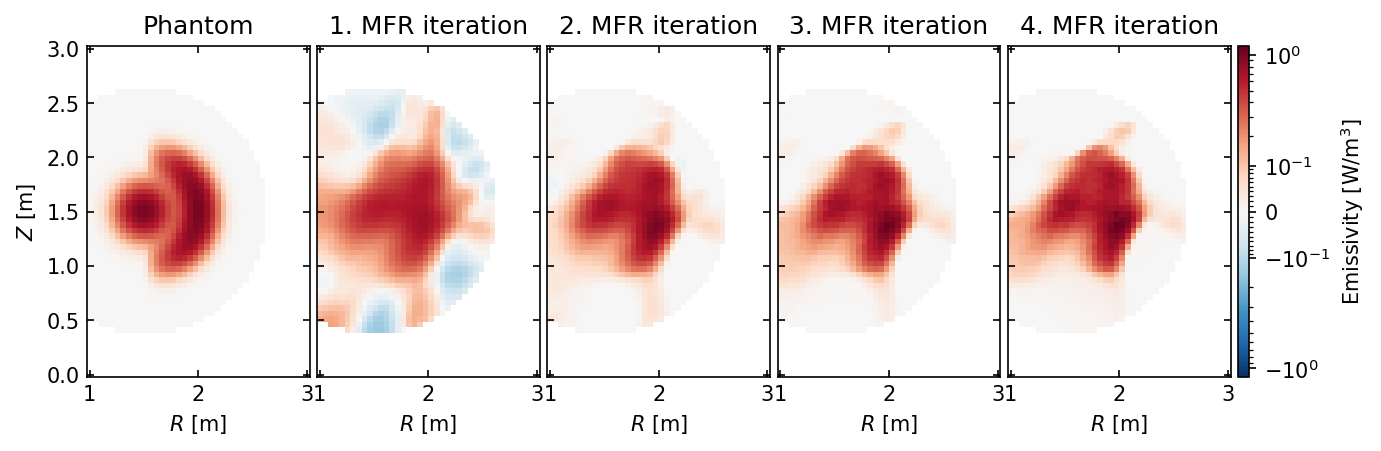

In [20]:
# Stored regularizer files
reg_files = list(Path().cwd().glob("regularizer_*.pickle"))
reg_files = sorted(reg_files, key=lambda x: int(x.stem.split("_")[-1]))

# Load each solutions
sols = []
regs = []
for file in reg_files:
    with open(file, "rb") as f:
        reg = pickle.load(f)

    sols.append(reg.solution(reg.lambda_opt))
    regs.append(reg)

profiles = [phantom] + sols

# set vmin and vmax for all solutions
vmin = min(profile.min() for profile in profiles)
vmax = max(profile.max() for profile in profiles)


# Plot the solutions
fig = plt.figure(figsize=(10, 5))
grids = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, len(profiles)),
    axes_pad=0.05,
    cbar_mode="single",
    cbar_location="right",
)

absolute = max(abs(vmax), abs(vmin))
linear_width = 1e-1  # linear region width
norm = AsinhNorm(linear_width=linear_width, vmin=-1 * absolute, vmax=absolute)
i = 0
for ax, profile in zip(grids.axes_all, profiles, strict=True):
    sol_2d = np.full(voxel_map.shape, np.nan)
    sol_2d[mask[:, :]] = profile

    ax.imshow(
        sol_2d.T,
        origin="lower",
        cmap="RdBu_r",
        extent=(rmin, rmax, zmin, zmax),
        norm=norm,
    )
    if i == 0:
        ax.set_title("Phantom")
    else:
        ax.set_title(f"{i}. MFR iteration")

    ax.set_xlabel("$R$ [m]")
    i += 1

    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

grids[0].set_ylabel("$Z$ [m]")
mappable = ScalarMappable(norm=norm, cmap="RdBu_r")
cbar = plt.colorbar(mappable, cax=grids.cbar_axes[0])
cbar.set_label("Emissivity [W/m$^3$]")
fmt = LogFormatterSciNotation(linthresh=linear_width)
major_locator = SymmetricalLogLocator(linthresh=linear_width, base=10)
minor_locator = SymmetricalLogLocator(
    linthresh=linear_width, base=10, subs=tuple(np.arange(0.1, 1.0, 0.1))
)
cbar.ax.yaxis.set_offset_position("left")
cbar.ax.yaxis.set_major_formatter(fmt)
cbar.ax.yaxis.set_major_locator(major_locator)
cbar.ax.yaxis.set_minor_locator(minor_locator);

### Quantitative evaluation history

The following plots shows the quantitative evaluation changes during the iteration.


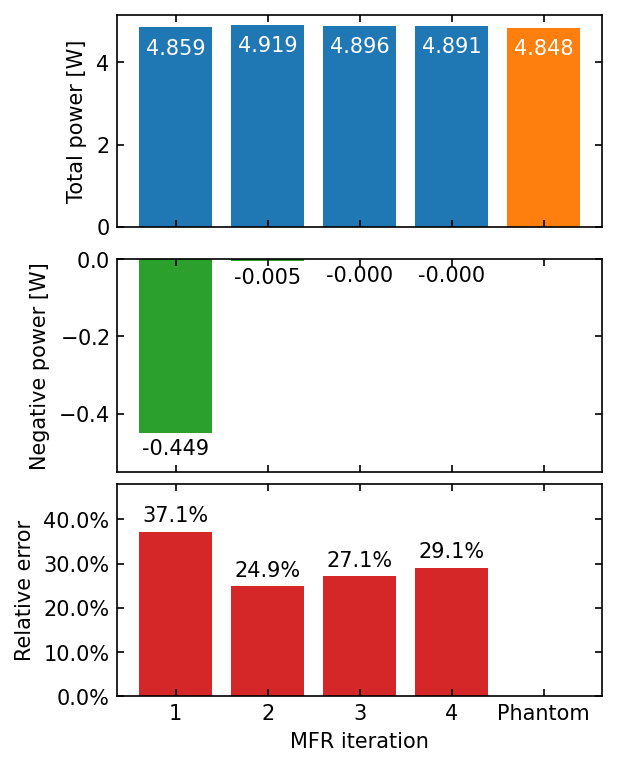

In [21]:
relative_errors = []
total_powers = []
negative_powers = []

for sol in sols:
    relative_errors.append(np.linalg.norm(sol - phantom) / np.linalg.norm(phantom))
    total_powers.append(sol @ volumes)
    negative_powers.append(sol[sol < 0] @ volumes[sol < 0])

# Append nan value to the last iteration
relative_errors.append(np.nan)
negative_powers.append(np.nan)

# show each values as a bar plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout="constrained", sharex=True, figsize=(4, 5))

x = np.arange(1, len(relative_errors) + 1)  # the label locations
rects = ax1.bar(x[:4], total_powers, color="C0", label="Reconstruction")
ax1.bar_label(rects, padding=-15, fmt="{:.3f}", color="w")
rects = ax1.bar(x[-1], np.sum(phantom * volumes), color="C1", label="Phantom")
ax1.bar_label(rects, padding=-15, fmt="{:.3f}", color="w")
ax1.set_ylabel("Total power [W]")
ax1.tick_params(axis="both", which="both", direction="in", top=True, right=True)
ax1.ticklabel_format(style="sci", axis="y", useMathText=True)


rects = ax2.bar(x, negative_powers, color="C2")
ax2.bar_label(rects, padding=3, fmt="{:.3f}")
ax2.set_ylim(ymin=-0.55)
ax2.set_ylabel("Negative power [W]")
ax2.tick_params(axis="both", which="both", direction="in", top=True, right=True)
ax2.ticklabel_format(style="sci", axis="y", useMathText=True)

rects = ax3.bar(x, relative_errors, color="C3")
ax3.bar_label(rects, padding=3, fmt="{:.1%}")
ax3.set_ylim(ymax=0.48)
ax3.set_ylabel("Relative error")
ax3.set_xlabel("MFR iteration")
ax3.set_xticks(x)
ax3.set_xticklabels(x.tolist()[:4] + ["Phantom"])
ax3.tick_params(axis="both", which="both", direction="in", top=True, right=True)
ax3.yaxis.set_major_formatter(PercentFormatter(xmax=1))

In this example, the minimum relative error is achieved at the 2nd iteration.


### Solution bases history

Solution bases are also altered during the iteration, where they are localized to the regions as the
iteration proceeds.


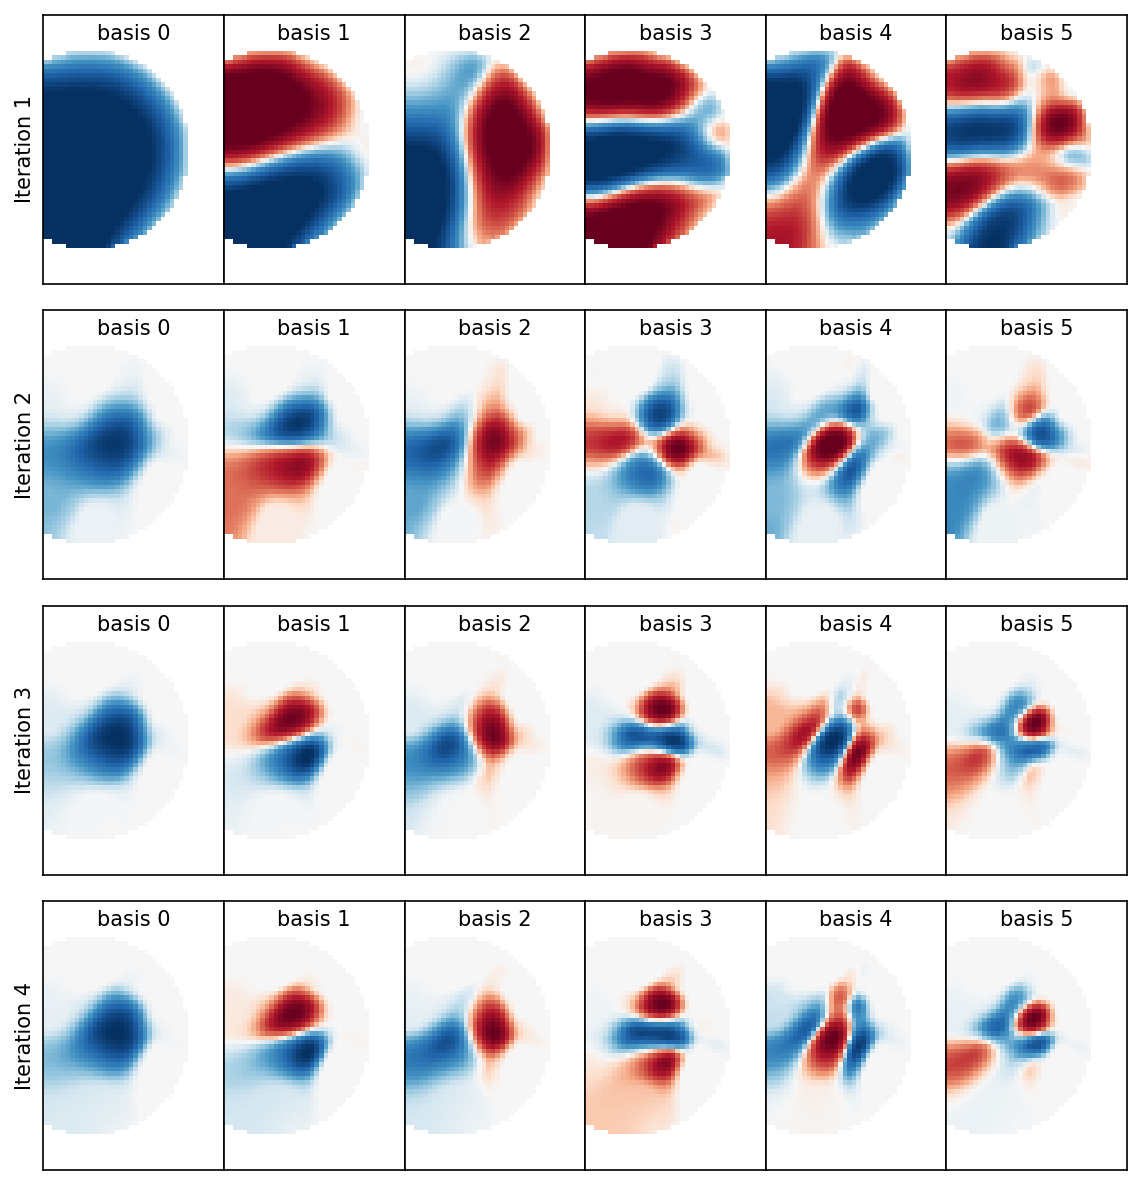

In [22]:
# Plot solution bases
fig = plt.figure(figsize=(16, 10))

for j, reg in enumerate(regs):
    grids = ImageGrid(
        fig,
        (len(sols), 1, j + 1),
        nrows_ncols=(1, 6),
        axes_pad=0.0,
        cbar_mode=None,
    )

    grids[0].set_ylabel(f"Iteration {j + 1}")

    for i, ax in enumerate(grids.axes_all):
        profile2d = np.full(voxel_map.shape, np.nan)
        profile2d[mask[:, :]] = reg.basis[:, i]

        absolute = max(abs(lcurve.basis[:, i].min()), abs(lcurve.basis[:, i].max()))
        norm = AsinhNorm(vmin=-1 * absolute, vmax=absolute, linear_width=absolute * 1e-1)

        ax.imshow(
            profile2d.T,
            origin="lower",
            cmap="RdBu_r",
            extent=(rmin, rmax, zmin, zmax),
            norm=norm,
        )
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        ax.text(
            0.5,
            0.93,
            f"basis {i}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

fig.subplots_adjust(hspace=0.1)

Solution bases are getting broaden toward the left and bottom edges as the iteration proceeds, which
seems to be because of no boundary restriction comming from backward difference derivatives.
Dropping the solution to zero at the boundary is realized by using anisotropic smoothing regularization,
for example, numerical derivative matrices based on different coordinates system like the polar coordinate system.

The example [MFR tomography with anisotropic derivatives](02-mfr-aniso-derivative.ipynb) shows the anisotropic smoothing regularization using derivative matrices derived from different scheams.
